In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

import pingouin as pg

C:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sys
import os
sys.path.append(os.path.join(".."))

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','SAFECOM_data.csv')
df = pd.read_csv(csv_file_name)#pd.read_excel(csv_file_name,sheet_name='safecom-2011-present-NASA')
fire_missions = [mission for mission in list(df['Mission Type']) if type(mission) is str and 'fire' in mission.lower()]
df = df.loc[df['Mission Type'].isin(fire_missions)].reset_index(drop=True)
df['Year'] = [df.at[i,'Date'].split('/')[-1] for i in range(len(df))]
df['Day'] = [df.at[i,'Date'].split('/')[1] for i in range(len(df))]
df['Month'] = [df.at[i,'Date'].split('/')[0] for i in range(len(df))]
#df['Year'].value_counts()

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#NIFC based in boise
#idaho and wyoming are split in regions
def correct_regions(df):
    region_dict ={
        'Region 05 Pacific Southwest Region': ['5', 'California', 'Hawaii', 'Pacific West Regional Office','California State Office','R2-Southwest Regional Office'],
        'Region 06 Pacific Northwest Region':['Oregon/Washington State Office', 'Washington', 'Oregon', 'Washington Office','R9-Washington Office',
                                             'PNW Research Station FIA','R1-Pacific Regional Office'],
        'Region 01 Northern Rockies Region':['Montana/Dakotas State Office', 'Montana'], 
        'Region 04 Intermountain Region':['Nevada State Office','DOI-OAS - Headquarters Boise', 'Intermountain Regional NPS Headquarters',
                                         'Utah','Utah State Office', 'Nevada', 'National Interagency Fire Center', 'DOI-OAS - Western Region Office',
                                         'DOI-OAS - Technical Services', 'DOI-OAS - Unmanned Aircraft System Office'],
        'Region 03 Southwest Region':['Southeast Region','Arizona State Office','Arizona','New Mexico','New Mexico State Office'],
        'Region 09 Eastern Area Region':['New Jersey', 'Pennsylvania', 'Minnesota','Pennsylvania','Midwest Regional NPS Headquarters','R3-Great Lakes - Big Rivers Regional Office',
                                        'Northeast Regional Office', 'DOI-OAS - Eastern Region Office','Northeastern Area, S&PF','Wisconsin','Eastern States Office','National Capitol Parks'],
        'Region 02 Rocky Mountain Region':['Colorado State Office', 'Colorado','R6-Mountain-Praire Regional Office', 'DMBM - Migratory Birds', 'Wyoming'], 
        'Region 08 Southern Area Region':['Gulf of Mexico Region','Texas','Oklahoma','North Carolina', 'South Carolina','Florida','R4-Southeast Regional Office'],
        'Region 10 Alaska Region': ['Alaska State Office','Alaska OCS Region', 'Alaska Regional Office', 'Alaska','DOI-OAS - Alaska Regional Office',
                                   'R7-Alaska Regional Office']

    }
    regions_corrected = []
    indices_to_drop = []
    for i in range(len(df)):
        current_region = df.iloc[i]['Region']
        correct_region = None
        for region in region_dict:
            if (region == current_region) or (current_region in region_dict[region]):
                correct_region = region
                break 
        if not correct_region:
            correct_region = current_region
        if correct_region in ['CAMP â€“ Campaign Against Marijuana Program', 'Commercial Aircraft Services', 'Aircraft Operations Center','National Capitol Parks', 'Department of Defense', 'National Guard']:
            indices_to_drop.append(i)
        if correct_region == 'Idaho':
            if df.iloc[i]['Location'] in ['Clear Creak Fire', 'garden valley', 'Idaho City', 'Idaho City Helibase (U98)','Ranft Fire']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 01 Northern Rockies Region'
        elif correct_region == 'Pacific Region':
            correct_region = 'Region 05 Pacific Southwest Region'
        elif correct_region == 'Idaho State Office':
            if df.iloc[i]['Location'] in ['Granite Creek Fire', '47.512775, -116.002886','Post Falls, ID']:
                correct_region = 'Region 01 Northern Rockies Region'
            else: 
                correct_region = 'Region 04 Intermountain Region'
        elif correct_region == 'Wyoming State Office':
            if df.iloc[i]['Location'] in ['Tokewanna Fire','Rock Springs Sweetwater County', 'Evanston, WY Airport']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 02 Rocky Mountain Region'
        regions_corrected.append(correct_region)

    df['region_corrected'] = regions_corrected
    df = df.drop(indices_to_drop, axis=0).reset_index(drop=True)
    return df

In [5]:
list_of_attributes = ['Narrative']#, 'corrective_public', 'notes']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident	Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join(os.path.dirname(os.getcwd()),'results','safecom_topics_Feb-17-2022','preprocessed_data.csv')
safecom = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, combine_cols=False)
safecom.extract_preprocessed_data(file)
preprocessed_df = safecom.data_df
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [6]:
preprocessed_df = preprocessed_df.loc[ preprocessed_df['Year'].astype(int)<2021].reset_index(drop=True)

In [7]:
hazard_file = os.path.join(os.path.dirname(os.getcwd()),'results','safecom_topics_Feb-17-2022','hazard_interpretation_SAFECOM_V0.xlsx')
results_file = os.path.join(os.path.dirname(os.getcwd()),'results','safecom_topics_Feb-17-2022','lda_results.xlsx')

In [8]:
hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])

In [9]:
frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #")

In [10]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [11]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    for hazard in hazards:
        for year in docs[hazard]:
            year = str(year)
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[year]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = total_hazard_freq[hazard]/total_docs
        total_severities_hazard[hazard] = np.average([sev for year in severities[hazard] for sev in severities[hazard][year]])
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    return table, severities, rates
    

In [12]:
categories = ['Airspace','Incident','Maintenance', 'Hazard', 'Incident']
subcategories = ["UAS", 'Mission Equipment','Landing Gear', 'Weather', 'Aircraft Damage']
hazards = ['Drone Incursion','Water Drop','Hydraulic Fluid Issues', 'Wind', 'Wing Damage']
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year')

In [13]:
table

,Category,Subcategory,Hazards,Frequency,Rate,Severity
0,Airspace,UAS,Drone Incursion,175,0.012033,0.125714
1,Incident,Mission Equipment,Water Drop,847,0.058241,0.323495
2,Maintenance,Landing Gear,Hydraulic Fluid Issues,363,0.024960,0.115702
3,Hazard,Weather,Wind,303,0.020835,0.633663
4,Incident,Aircraft Damage,Wing Damage,85,0.005845,1.188235


In [14]:
def plot_metric_time_series(metric_data, metric_name, line_styles=[], markers=[], title="", time_name="Year", scaled=False, xtick_freq=5):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    #scaled -> scaled the averages, how to scale stddev?
    if scaled: metric_data = {hazard: minmax_scale(metric_data[hazard]) for hazard in metric_data}
    averages = {hazard: [np.average(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    stddevs = {hazard: [np.std(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    colors = cm.tab20(np.linspace(0, 1, len(averages)))
    plt.figure()
    plt.title(title, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    i=0
    for hazard in averages:
        plt.errorbar(time_vals, averages[hazard], yerr=stddevs[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard, capsize=5, markeredgewidth=1)
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.xticks(np.arange(1, int(len(time_vals))+1, xtick_freq),rotation=45)
    plt.tick_params(labelsize=16)
    plt.show()
    

In [15]:
def plot_frequency_time_series(metric_data, metric_name='Frequency', line_styles=[], markers=[], title="", time_name="Year", xtick_freq=5):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    frequencies = {hazard: [frequency[hazard][year] for year in time_vals] for hazard in frequency}
    hazard_freqs_scaled = {hazard: minmax_scale(frequencies[hazard]) for hazard in frequencies}
    colors = cm.tab20(np.linspace(0, 1, len(frequencies)))
    plt.figure()
    plt.ylabel("Total Scaled "+metric_name, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.title(title, fontsize=16)
    i = 0
    for hazard in hazard_freqs_scaled:
        plt.plot(time_vals, hazard_freqs_scaled[hazard], color=colors[i], label=hazard, marker=markers[i], linestyle=line_styles[i])
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.xticks(np.arange(1, int(len(time_vals))+1, xtick_freq),rotation=45)
    plt.tick_params(labelsize=16)
    plt.show()

C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


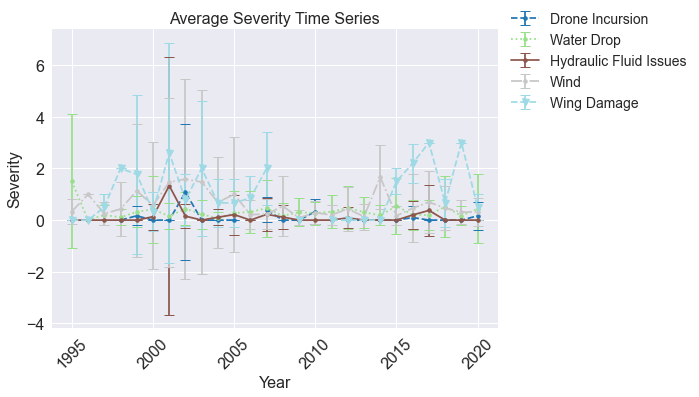

In [16]:
markers = ['.','.','.', '.', 'v']
line_styles = ['--', ':','-', '-.','--']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity Time Series", time_name='Year')

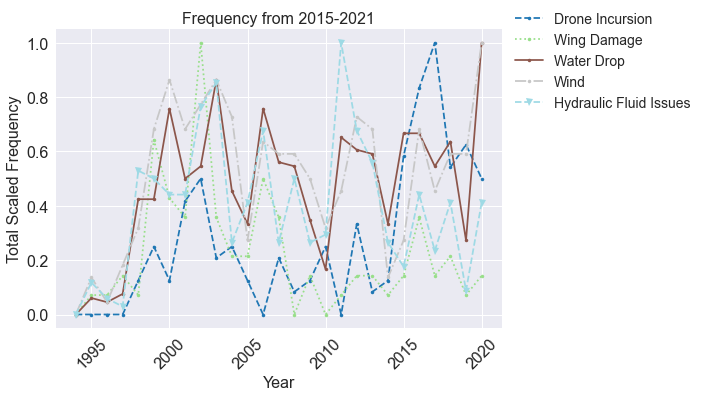

In [17]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 2015-2021", time_name="Year")

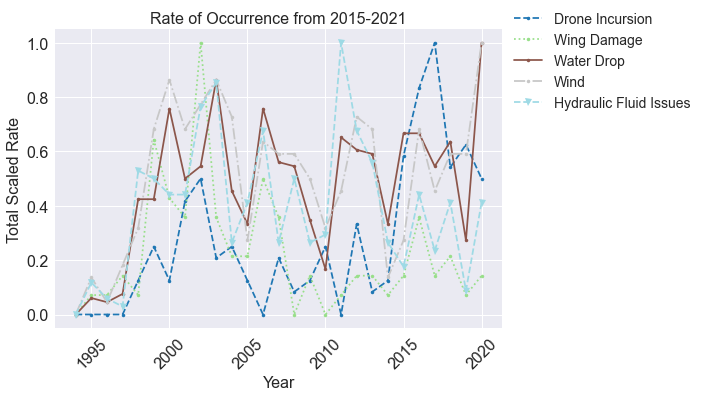

In [18]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 2015-2021", time_name="Year")

# Pie Charts

In [19]:
def make_pie_chart(docs, data, predictor, hazards, id_field, predictor_label=None):
    if not predictor_label: predictor_label=predictor
    num_rows = int(np.ceil(len(hazards)/3))
    extra_axes = len(hazards)%3
    fig, axes = plt.subplots(num_rows, 3, figsize=(10,5))
    if extra_axes>0:
        for x in range(1,extra_axes):
            fig.delaxes(axes[num_rows-1][3-x])
    for ax, hazard in zip(axes.flatten(), hazards):
        total_docs = [doc for year in docs[hazard] for doc in docs[hazard][year]]
        hazard_data = data.loc[data[id_field].isin(total_docs)].reset_index(drop=True)
        label = hazard_data[predictor].value_counts().index.sort_values()
        values = [hazard_data[predictor].value_counts()[val] for val in label]
        colors = cm.coolwarm(np.linspace(0, 1, len(label)))
        ax.pie(values, labels=label, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 12},labeldistance=None, pctdistance=1.2)
        ax.set_title(hazard+" per "+predictor_label, fontdict={'fontsize': 14})
    axes[0,0].legend(bbox_to_anchor=(-0.2, 1),fontsize=14)
    plt.show()

In [20]:
correct_regions(preprocessed_df)

,Agency,Region,Location,Date,Date Submitted,Tracking #,Mission Type,Persons Onboard,Departure Point,Destination,...,UAS,Accident,Airspace,Maintenance,Mishap Prevention,Raw_Narrative,Year,Day,Month,region_corrected
0,Bureau of Land Management (BLM),Alaska State Office,Fairbanks,05/10/1995,NaN,95-0002,"Fire, Smokejumper",1.0,Fairbanks,NaN,...,NaN,NaN,Intrusion,NaN,NaN,On a practice parachute jump a single engine a...,1995,10,05,Region 10 Alaska Region
1,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/10/1995,NaN,95-0003,"Fire, Smokejumper",4.0,Birch Hill,NaN,...,NaN,NaN,Intrusion,NaN,NaN,NXXXXX 5-10-95 A small airplane flew thr...,1995,10,05,Region 10 Alaska Region
2,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/09/1995,NaN,95-0004,"Fire, Air Attack",2.0,Fort Wainwright,NaN,...,NaN,NaN,NaN,Electrical,NaN,"After takeoff from Ft. Wainwight, left generat...",1995,09,05,Region 10 Alaska Region
3,Bureau of Land Management (BLM),California State Office,BFL,07/28/1995,NaN,95-0006,"Fire, Air Attack",2.0,BFL CA.,NaN,...,NaN,NaN,NaN,Hydraulic,NaN,Firewall fitting cracked - leaking hydraulic f...,1995,28,07,Region 05 Pacific Southwest Region
4,Bureau of Land Management (BLM),Alaska State Office,6 Mi East of FBK,07/16/1995,NaN,95-0007,Ferry/Repositioning Flight (Non-Fire),2.0,FBK,BOI,...,NaN,NaN,NaN,NaN,NaN,I have debated with myself if I should file a ...,1995,16,07,Region 10 Alaska Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14533,State,California,McClellan Reload Base,12/20/2020,NaN,21-0151,"Fire, Leadplane",0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Prior to pilots' preflight, ATS noticed eviden...",2020,20,12,Region 05 Pacific Southwest Region
14534,State,California,Hemet Airport,12/24/2020,NaN,21-0152,"Fire, Retardant Drop (Airtanker)",1.0,KHMT,KRNM,...,NaN,NaN,NaN,NaN,NaN,While fueling at Ramona AAB after 2.5 hour fue...,2020,24,12,Region 05 Pacific Southwest Region
14535,State,California,Camp Pendleton,12/24/2020,NaN,21-0154,"Fire, Water Drop (Helicopter Fixed-Tank)",3.0,KCRQ,Creek Fire Camp Pendleton,...,NaN,NaN,NaN,NaN,NaN,While engaged in a water dropping mission HT-7...,2020,24,12,Region 05 Pacific Southwest Region
14536,U.S. Geological Survey (USGS),NaN,Hawaii Volcanoes National Park,12/29/2020,NaN,21-0155,Survey/Observation (Non-Fire),0.0,"Crater Rim Dr., west of Kilauea Caldera","Crater Rim Dr., west of Kilauea Caldera",...,"UAS, Fleet Operation, Loss of Link",NaN,NaN,NaN,NaN,A team of two pilots began flying on Crater Ri...,2020,29,12,NaN


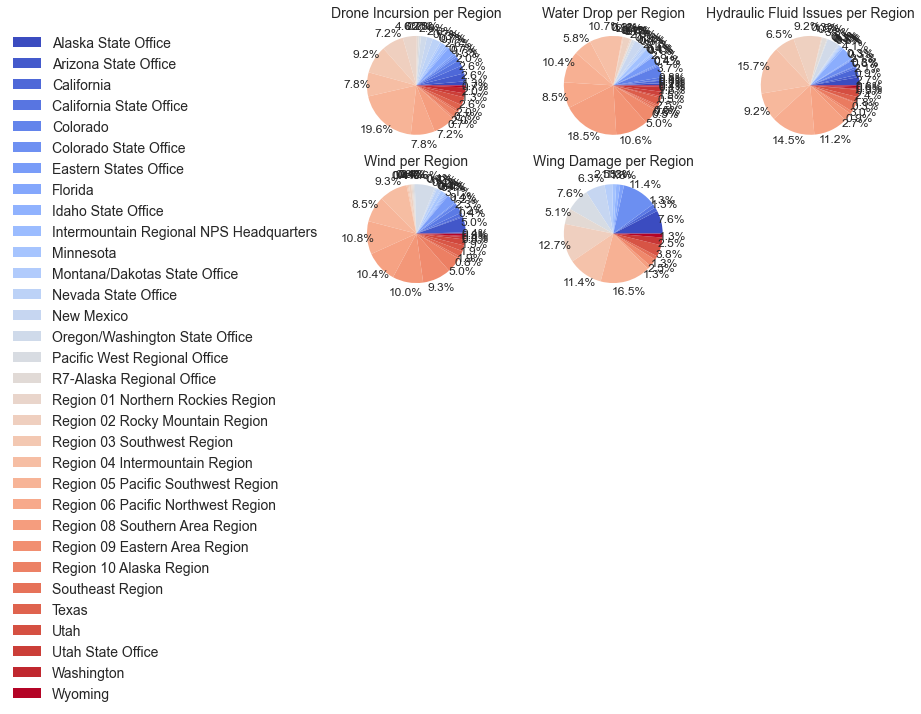

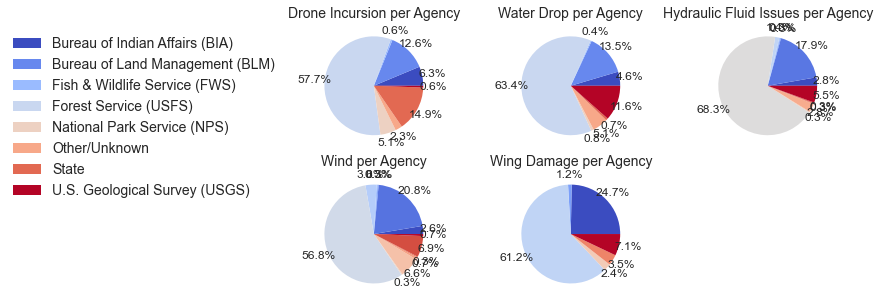

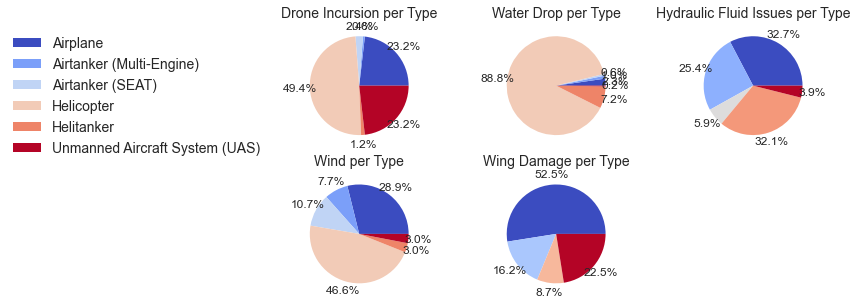

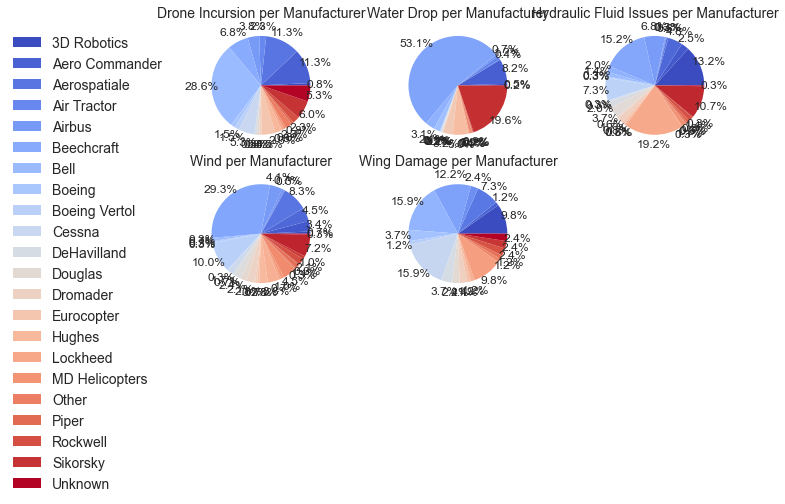

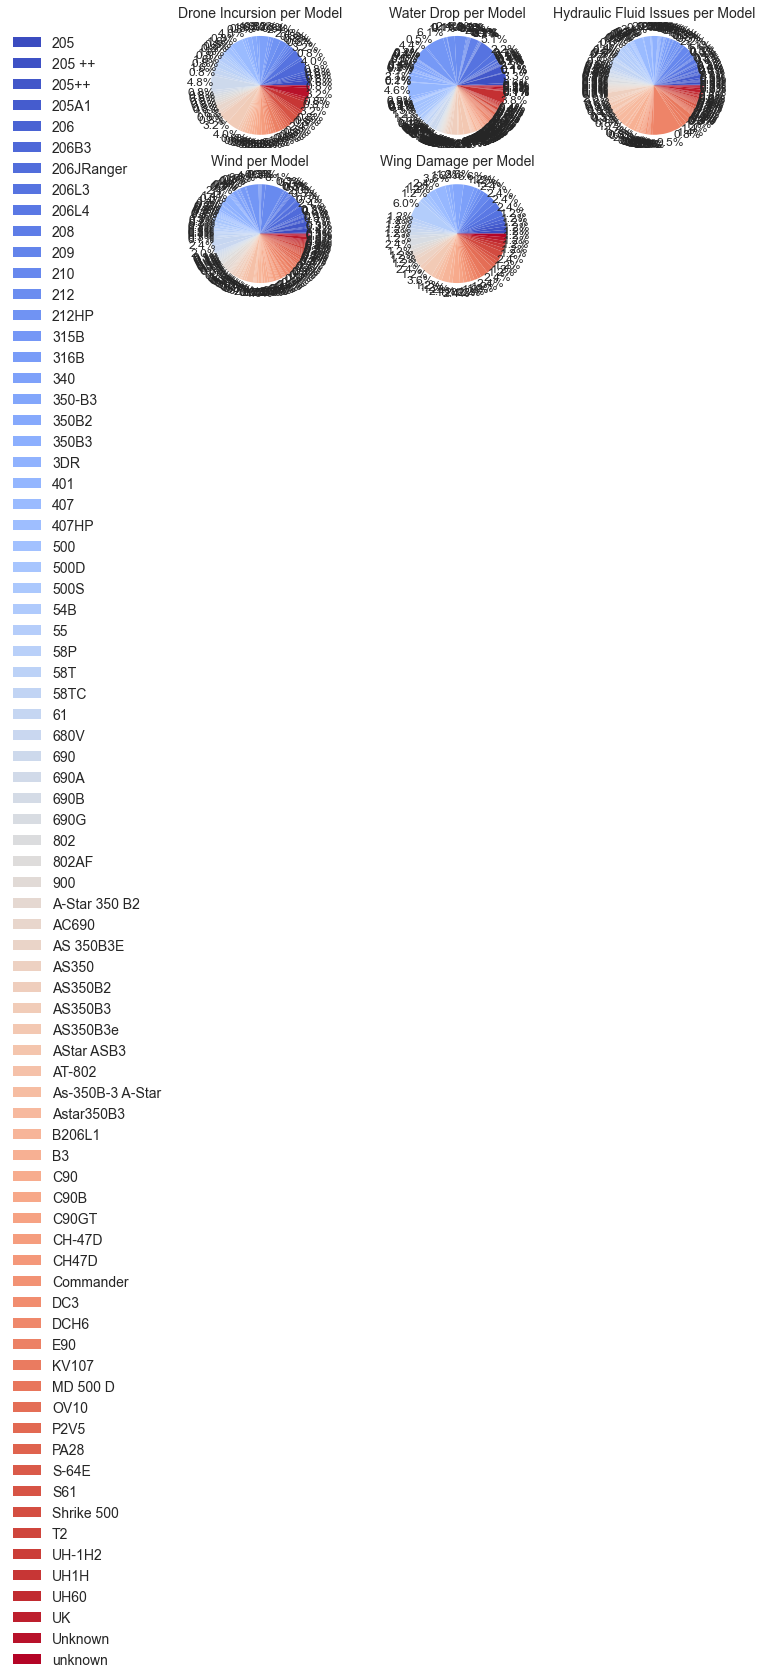

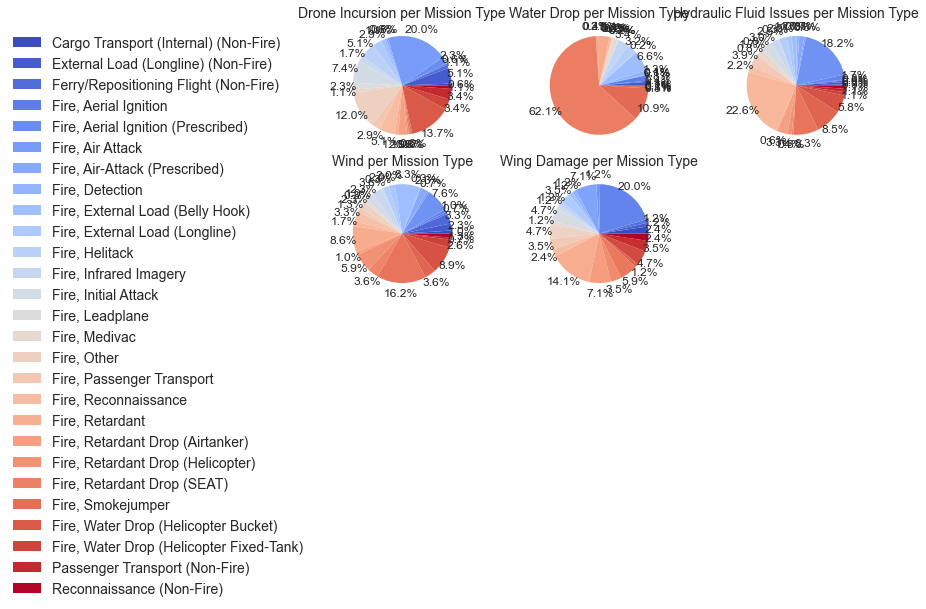

In [21]:
predictors = ['Region', 'Agency', 'Type', 'Manufacturer', 'Model','Mission Type']
for predictor in predictors:
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor)

# Chi-Squared Analysis

In [22]:
#add hazard values to preprocessed_df
hazards_per_doc = {doc:[] for doc in preprocessed_df['Tracking #']}
hazards_for_df = {hazard:[0 for i in range(len(preprocessed_df))] for hazard in docs}
for hazard in docs:
    for year in docs[hazard]:
        for doc in docs[hazard][year]:
            hazards_for_df[hazard][preprocessed_df.index[preprocessed_df['Tracking #']==doc].tolist()[0]] = 1
    preprocessed_df[hazard] = hazards_for_df[hazard]
#add severities
severities = []
for i in range(len(preprocessed_df)):
    severities.append(safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']))
preprocessed_df["severity"] = severities

In [23]:
count_dfs = {}
stat_vals = {pred: [] for pred in predictors}
for predictor in predictors:
    vals = []
    hazard_vals = []
    pred_vals = [val for val in preprocessed_df[predictor].value_counts().index]
    diff_observed_expected = {pred_val:[] for pred_val in pred_vals}
    for hazard in hazards:
        expected, observed, stats = pg.chi2_independence(preprocessed_df, x=predictor,y=hazard)
        stat_vals[predictor].append((stats.iloc[0]['pval'].round(3)))
        stat_vals[predictor].append((stats.iloc[0]['chi2'].round(3)))
        for i in range(len(expected)):
            pred_val = expected.index[i]
            diff_observed_expected[pred_val].append(observed.iloc[i][0] - expected.iloc[i][0])
            diff_observed_expected[pred_val].append(observed.iloc[i][1] - expected.iloc[i][1])
    iterables = [hazards, [0,1]]
    index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Present"])
    pred_df = pd.DataFrame(diff_observed_expected, index=index)
    count_dfs[predictor] = pred_df
iterables = [hazards, ["p-val", "chi-squared"]]
index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Measure"])
stats_df = pd.DataFrame(stat_vals, index=index)

C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


In [24]:
stats_df

Region  Agency      Type  Manufacturer  \
Hazard                 Measure                                                
Drone Incursion        p-val          0.000   0.008     0.000         0.000   
                       chi-squared  236.126  31.142  1285.491       121.709   
Water Drop             p-val          0.000   0.000     0.000         0.000   
                       chi-squared  151.408  63.509   539.510       636.099   
Hydraulic Fluid Issues p-val          0.314   0.845     0.000         0.000   
                       chi-squared   76.220   9.590    96.219       169.435   
Wind                   p-val          0.000   0.016     0.000         0.000   
                       chi-squared  129.554  29.055    60.678       201.885   
Wing Damage            p-val          0.017   0.607     0.000         0.015   
                       chi-squared   98.456  12.943    47.701        91.015   

                                       Model  Mission Type  
Hazard                 Measure                              
Drone Incursion        p-val           0.000         0.000  
                       chi-squared  2115.147       136.416  
Water Drop             p-val           0.000         0.000  
                       chi-squared  2011.103      2032.001  
Hydraulic Fluid Issues p-val           0.001         0.000  
                       chi-squared  1540.490       128.468  
Wind                   p-val           0.000         0.000  
                       chi-squared  1794.247        84.773  
Wing Damage            p-val           1.000         0.007  
                       chi-squared  1158.736        64.160

In [25]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                 Present                                       
Drone Incursion        0                                 -5.052066   
                       1                                  5.052066   
Water Drop             0                                -16.564796   
                       1                                 16.564796   
Hydraulic Fluid Issues 0                                  6.113737   
                       1                                 -6.113737   
Wind                   0                                 16.232124   
                       1                                -16.232124   
Wing Damage            0                                  3.881613   
                       1                                 -3.881613   

                                Region 06 Pacific Northwest Region  \
Hazard                 Present                                       
Drone Incursion        0                                  6.929639   
                       1                                 -6.929639   
Water Drop             0                                 13.658408   
                       1                                -13.658408   
Hydraulic Fluid Issues 0                                  3.818417   
                       1                                 -3.818417   
Wind                   0                                  8.044290   
                       1                                 -8.044290   
Wing Damage            0                                 -3.225873   
                       1                                  3.225873   

                                Region 03 Southwest Region  \
Hazard                 Present                               
Drone Incursion        0                          1.313996   
                       1                         -1.313996   
Water Drop             0                         -3.230752   
                       1                          3.230752   
Hydraulic Fluid Issues 0                        -19.169081   
                       1                         19.169081   
Wind                   0                         -2.076307   
                       1                          2.076307   
Wing Damage            0                          3.907227   
                       1                         -3.907227   

                                Region 04 Intermountain Region  \
Hazard                 Present                                   
Drone Incursion        0                              1.214591   
                       1                             -1.214591   
Water Drop             0                              1.381994   
                       1                             -1.381994   
Hydraulic Fluid Issues 0                             -1.806983   
                       1                              1.806983   
Wind                   0                             -4.630203   
                       1                              4.630203   
Wing Damage            0                             -3.176780   
                       1                              3.176780   

                                Region 01 Northern Rockies Region  \
Hazard                 Present                                      
Drone Incursion        0                                 5.608096   
                       1                                -5.608096   
Water Drop             0                               -18.618768   
                       1                                18.618768   
Hydraulic Fluid Issues 0                                -3.146821   
                       1                                 3.146821   
Wind                   0                                -2.656884   
                       1                                 2.656884   
Wing Damage            0                                 1.510063   
                       1                             

Forest Service (USFS)  \
Hazard                 Present                          
Drone Incursion        0                    10.350506   
                       1                   -10.350506   
Water Drop             0                     1.936447   
                       1                    -1.936447   
Hydraulic Fluid Issues 0                   -17.027237   
                       1                    17.027237   
Wind                   0                    20.795447   
                       1                   -20.795447   
Wing Damage            0                     2.084531   
                       1                    -2.084531   

                                Bureau of Land Management (BLM)      State  \
Hazard                 Present                                               
Drone Incursion        0                               9.331247 -12.687530   
                       1                              -9.331247  12.687530   
Water Drop             0                              37.643235 -33.567646   
                       1                             -37.643235  33.567646   
Hydraulic Fluid Issues 0                              -0.010042   7.613866   
                       1                               0.010042  -7.613866   
Wind                   0                              -8.752184   2.049591   
                       1                               8.752184  -2.049591   
Wing Damage            0                              -5.781966   0.466057   
                       1                               5.781966  -0.466057   

                                National Park Service (NPS)  \
Hazard                 Present                                
Drone Incursion        0                          -1.453057   
                       1                           1.453057   
Water Drop             0                          -6.472797   
                       1                           6.472797   
Hydraulic Fluid Issues 0                           5.654515   
                       1                          -5.654515   
Wind                   0                          -6.933008   
                       1                           6.933008   
Wing Damage            0                           1.665658   
                       1                          -1.665658   

                                Bureau of Indian Affairs (BIA)  \
Hazard                 Present                                   
Drone Incursion        0                             -5.884449   
                       1                              5.884449   
Water Drop             0                            -14.240732   
                       1                             14.240732   
Hydraulic Fluid Issues 0                              0.611115   
                       1                             -0.611115   
Wind                   0                              0.857212   
                       1                             -0.857212   
Wing Damage            0                              2.484696   
                       1                             -2.484696   

                                Fish & Wildlife Service (FWS)  Other/Unknown  \
Hazard                 Present                                                 
Drone Incursion        0                             1.250843      -2.363024   
                       1                            -1.250843       2.363024   
Water Drop             0                             7.894078       1.922966   
                       1                            -7.894078      -1.922966   
Hydraulic Fluid Issues 0                            -0.331109       2.395557   
                       1                             0.331109      -2.395557   
Wind                   0                            -7.102827       1.834308   
                       1                             7.102827      -1.834308   
Wing Damage            0                             0.09326

Helicopter    Airplane  \
Hazard                 Present                           
Drone Incursion        0          7.948562    2.227292   
                       1         -7.948562   -2.227292   
Water Drop             0       -288.579283  186.061074   
                       1        288.579283 -186.061074   
Hydraulic Fluid Issues 0         79.168202  -29.186765   
                       1        -79.168202   29.186765   
Wind                   0         22.626045  -12.904067   
                       1        -22.626045   12.904067   
Wing Damage            0         25.389542  -22.376931   
                       1        -25.389542   22.376931   

                                Airtanker (Multi-Engine)  Airtanker (SEAT)  \
Hazard                 Present                                               
Drone Incursion        0                       19.462236          3.645742   
                       1                      -19.462236         -3.645742   
Water Drop             0                       96.307496         33.974635   
                       1                      -96.307496        -33.974635   
Hydraulic Fluid Issues 0                      -46.332436         -4.309905   
                       1                       46.332436          4.309905   
Wind                   0                       14.181380        -18.107128   
                       1                      -14.181380         18.107128   
Wing Damage            0                       -3.018421         -3.270370   
                       1                        3.018421          3.270370   

                                Helitanker  Unmanned Aircraft System (UAS)  
Hazard                 Present                                              
Drone Incursion        0          3.623920                      -36.907751  
                       1         -3.623920                       36.907751  
Water Drop             0        -31.331727                        3.567805  
                       1         31.331727                       -3.567805  
Hydraulic Fluid Issues 0         -1.723395                        2.384299  
                       1          1.723395                       -2.384299  
Wind                   0          1.219073                       -7.015304  
                       1         -1.219073                        7.015304  
Wing Damage            0          2.743375                        0.532804  
                       1         -2.743375                       -0.532804

Bell   Sikorsky   Lockheed     Cessna  \
Hazard                 Present                                                
Drone Incursion        0          6.336573   4.906394   9.661381   3.398977   
                       1         -6.336573  -4.906394  -9.661381  -3.398977   
Water Drop             0       -161.646767 -80.717866  62.491341  61.879430   
                       1        161.646767  80.717866 -62.491341 -61.879430   
Hydraulic Fluid Issues 0         64.341980  -3.550603 -39.542930   1.756668   
                       1        -64.341980   3.550603  39.542930  -1.756668   
Wind                   0         11.673730   7.141761  12.246620  -6.325539   
                       1        -11.673730  -7.141761 -12.246620   6.325539   
Wing Damage            0         14.335331   5.957326  -1.426818  -6.588601   
                       1        -14.335331  -5.957326   1.426818   6.588601   

                                Aerospatiale  Aero Commander  Beechcraft  \
Hazard                 Present                                             
Drone Incursion        0           -7.331969       -7.798465   -2.595396   
                       1            7.331969        7.798465    2.595396   
Water Drop             0          -19.896383       40.237998   33.342565   
                       1           19.896383      -40.237998  -33.342565   
Hydraulic Fluid Issues 0           11.467300      -27.777859   -6.905005   
                       1          -11.467300       27.777859    6.905005   
Wind                   0            3.719766        5.702594    1.964925   
                       1           -3.719766       -5.702594   -1.964925   
Wing Damage            0            3.727658       -3.559956   -6.051297   
                       1           -3.727658        3.559956    6.051297   

                                Air Tractor  Eurocopter    Douglas  ...  \
Hazard                 Present                                      ...   
Drone Incursion        0           1.509463   -2.413811   1.935038  ...   
                       1          -1.509463    2.413811  -1.935038  ...   
Water Drop             0          26.700986   -3.970552  17.029521  ...   
                       1         -26.700986    3.970552 -17.029521  ...   
Hydraulic Fluid Issues 0          -4.963464    3.572159  -5.165875  ...   
                       1           4.963464   -3.572159   5.165875  ...   
Wind                   0         -14.167336   -0.180490  -0.600292  ...   
                       1          14.167336    0.180490   0.600292  ...   
Wing Damage            0          -3.219730    1.211034  -0.190427  ...   
                       1           3.219730   -1.211034   0.190427  ...   

                                Schweitzer  MBB-Kawasaki  Champion  Republic  \
Hazard                 Present                                                 
Drone Incursion        0          0.009719      0.009719  0.009719  0.009719   
                       1         -0.009719     -0.009719 -0.009719 -0.009719   
Water Drop             0          0.059700      0.059700  0.059700  0.059700   
                       1         -0.059700     -0.059700 -0.059700 -0.059700   
Hydraulic Fluid Issues 0          0.025941      0.025941  0.025941  0.025941   
                       1         -0.025941     -0.025941 -0.025941 -0.025941   
Wind                   0          0.021191      0.021191  0.021191  0.021191   
                       1         -0.021191     -0.021191 -0.021191 -0.021191   
Wing Damage            0          0.005992      0.005992  0.005992  0.005992   
                       1         -0.005992     -0.005992 -0.005992 -0.005992   

                                Corvette  Normad-GAF     Gates  Bellanca  \
Hazard                 Present                                             
Drone Incursion        0        0.009719    0.009719  0.009719  0.009719   
                       1       -0.009719   -0.009719 -0.009719 -0.009719   
Water Drop

212        P2V     206L3        407  \
Hazard                 Present                                              
Drone Incursion        0         2.374408   5.190667  0.841560  -0.186001   
                       1        -2.374408  -5.190667 -0.841560   0.186001   
Water Drop             0       -15.109005  33.698141  0.431717  -6.747211   
                       1        15.109005 -33.698141 -0.431717   6.747211   
Hydraulic Fluid Issues 0         7.270142 -19.251914  9.756179  10.677871   
                       1        -7.270142  19.251914 -9.756179 -10.677871   
Wind                   0         0.497630   9.070361 -6.741451   7.194459   
                       1        -0.497630  -9.070361  6.741451  -7.194459   
Wing Damage            0         0.540284   2.419249  1.189282   3.171127   
                       1        -0.540284  -2.419249 -1.189282  -3.171127   

                                   206B3      212HP       UH1H     206L4  \
Hazard                 Present                                             
Drone Incursion        0       -0.966898  -0.372512  -1.602187  1.342690   
                       1        0.966898   0.372512   1.602187 -1.342690   
Water Drop             0        4.183157 -18.942180 -15.433248 -4.791105   
                       1       -4.183157  18.942180  15.433248  4.791105   
Hydraulic Fluid Issues 0        6.459132   4.465403   2.812833  2.656216   
                       1       -6.459132  -4.465403  -2.812833 -2.656216   
Wind                   0        6.378564   1.109953   2.575866  1.447685   
                       1       -6.378564  -1.109953  -2.575866 -1.447685   
Wing Damage            0        0.656726   1.730806   0.579511  0.543201   
                       1       -0.656726  -1.730806  -0.579511 -0.543201   

                                  205A1++     350B3  ...      500U       175  \
Hazard                 Present                       ...                       
Drone Incursion        0         2.250820  0.195698  ...  0.009187  0.009187   
                       1        -2.250820 -0.195698  ... -0.009187 -0.009187   
Water Drop             0       -27.387532 -2.745388  ...  0.059643  0.059643   
                       1        27.387532  2.745388  ... -0.059643 -0.059643   
Hydraulic Fluid Issues 0         4.395188  4.238571  ... -0.973897  0.026103   
                       1        -4.395188 -4.238571  ...  0.973897 -0.026103   
Wind                   0         0.234050  1.105869  ...  0.021363  0.021363   
                       1        -0.234050 -1.105869  ... -0.021363 -0.021363   
Wing Damage            0         1.482683  1.446373  ...  0.006052  0.006052   
                       1        -1.482683 -1.446373  ... -0.006052 -0.006052   

                                   C210T     P337G   CH-54 B   B206L-4  \
Hazard                 Present                                           
Drone Incursion        0        0.009187  0.009187  0.009187  0.009187   
                       1       -0.009187 -0.009187 -0.009187 -0.009187   
Water Drop             0        0.059643  0.059643  0.059643  0.059643   
                       1       -0.059643 -0.059643 -0.059643 -0.059643   
Hydraulic Fluid Issues 0        0.026103  0.026103  0.026103  0.026103   
                       1       -0.026103 -0.026103 -0.026103 -0.026103   
Wind                   0       -0.978637  0.021363  0.021363  0.021363   
                       1        0.978637 -0.021363 -0.021363 -0.021363   
Wing Damage            0        0.006052  0.006052  0.006052  0.006052   
                       1       -0.006052 -0.006052 -0.006052 -0.006052   

                                  Dash 8      P2-V    2006L1     S-63E  
Hazard                 Present                                          
Drone Incursion        0        0.009187  0.009187  0.009187  0.009187  
                       1       -0.009187 -0.009187 -0.009187 -0.009187  
Water Drop             0        0.059643  0.059643  0.0596

Fire, Water Drop (Helicopter Bucket)  \
Hazard                 Present                                         
Drone Incursion        0                                    1.185656   
                       1                                   -1.185656   
Water Drop             0                                 -404.101423   
                       1                                  404.101423   
Hydraulic Fluid Issues 0                                   22.242247   
                       1                                  -22.242247   
Wind                   0                                   -5.392835   
                       1                                    5.392835   
Wing Damage            0                                    7.233033   
                       1                                   -7.233033   

                                Fire, Air Attack  \
Hazard                 Present                     
Drone Incursion        0              -14.591556   
                       1               14.591556   
Water Drop             0               83.776869   
                       1              -83.776869   
Hydraulic Fluid Issues 0              -23.667056   
                       1               23.667056   
Wind                   0               12.335763   
                       1              -12.335763   
Wing Damage            0               -7.087327   
                       1                7.087327   

                                Fire, Retardant Drop (Airtanker)  \
Hazard                 Present                                     
Drone Incursion        0                               13.567352   
                       1                              -13.567352   
Water Drop             0                               83.865984   
                       1                              -83.865984   
Hydraulic Fluid Issues 0                              -43.486007   
                       1                               43.486007   
Wind                   0                                6.148044   
                       1                               -6.148044   
Wing Damage            0                               -2.981572   
                       1                                2.981572   

                                Fire, Reconnaissance  \
Hazard                 Present                         
Drone Incursion        0                    0.879323   
                       1                   -0.879323   
Water Drop             0                   44.815925   
                       1                  -44.815925   
Hydraulic Fluid Issues 0                    6.492539   
                       1                   -6.492539   
Wind                   0                    7.105343   
                       1                   -7.105343   
Wing Damage            0                    1.798529   
                       1                   -1.798529   

                                Passenger Transport (Non-Fire)  \
Hazard                 Present                                   
Drone Incursion        0                              3.410025   
                       1                             -3.410025   
Water Drop             0                             41.544523   
                       1                            -41.544523   
Hydraulic Fluid Issues 0                             -1.480919   
                       1                              1.480919   
Wind                   0                            -10.707213   
                       1                             10.707213   
Wing Damage            0                              0.570584   
                       1                             -0.570584   

                                Fire, Water Drop (Helicopter Fixed-Tank)  \
Hazard                 Present                                             
Drone Incursion        0                                        3.205460   
                       1       

# ANOVA 

In [26]:
anovas = []
for hazard in hazards:
    aov = pg.anova(dv='severity', between=hazard, ss_type=3, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Drone Incursion,1,14541,1.367,0.242,0.000
0,Water Drop,1,14541,12.245,0.000,0.001
0,Hydraulic Fluid Issues,1,14541,3.591,0.058,0.000
0,Wind,1,14541,59.425,0.000,0.004
0,Wing Damage,1,14541,87.869,0.000,0.006
